# Visualizing Nonbinary Trees: Classification of Chemical Isomers

This example lets you visualize the hierarchy of nonbinary trees. An example is the classification of chemical isomers, which are compounds that have the same chemical formula, but different arrangements of atoms in space.

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-12-18-Visualizing-Nonbinary-Trees-Classification-of-Chemical-Isomers.ipynb)*

Using this code will produce an ASCII art tree, where
- each parent item is on the level above its children
- a vertical line connects a parent to each of its children
- a horizontal line spans the width from the first to the last child for each parent

All you have to provide is the hierarchy, that is the name of each item and which item is its parent.

Here's the tree for classification of chemical isomers:


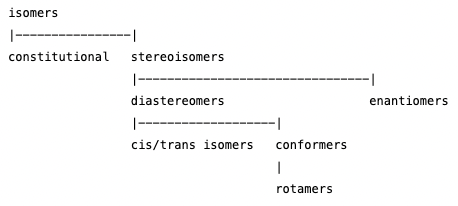

Here's the [isomerism diagram from Wikipedia](https://commons.wikimedia.org/wiki/File:Isomerism.svg) that it reproduces:

*Attribution: Vladsinger, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons*

This is an extension of a previous blog post I wrote about [retrosynthetic decomposition in RDKit]({% post_url 2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules %}). This code extends the `NonBinTree` class with the method  to allow 

## Code to generate trees

In [1]:
# Utility functions used by NonBinTree class

def n_by_1_empty_list(n: int) -> list[list]:
    """
    Create an n-by-1 empty list

    :param n: The number of empty (sub-)lists to include in the parent list
    :returns: The n-by-1 empty list, for example n=3 produces [[], [], []]
    """
    n_by_1_list = []
    for i in range(n):
        n_by_1_list += [[]]

    return n_by_1_list

def r_by_c_empty_string_list(r, c) -> list[list[str]]:
    """
    Create an r-by-c matrix (nested list where the length of each top-level list is the same) of empty strings

    :param r: The number of rows (top-level list)
    :param c: The number of columns (nested list)
    :returns: The r-by-c rectangular list of empty strings, for example r=2, c=3 produces [['', '', ''], ['', '', '']]
    """
    matrix = []
    for row_index in range(r):
        one_row = [""] * c
        matrix += [one_row]
        
    return matrix

def interleave(a: list[list], b: list[list]) -> list[list]:
    """
    Interleave (alternate the rows of) two matrices 
    (nested lists where the length of each top-level list is the same), for example
    a[0]
    b[0]
    a[1]
    b[1]
    a[2]
    where all the rows of a are shown, and the rows of b until either a or b runs out of rows.
    A row is a top-level list element; a column is the collection of the nth items in each row.

    :param a: The controlling nested list
    :param b: The following nested list
    :returns: The interleaved nested list
    """
    len_b = len(b)
    interleaved = []
    for row_index, row in enumerate(a):
        interleaved += [row]
        # If b hasn't run out of rows, insert corresponding row of b
        if row_index < len_b:
            interleaved += [b[row_index]]
    return interleaved

def longest_in_col(matrix: list[list]) -> list[int]:
    """
    Determine the length of the longest (for example, greatest number of characters)
    entry in each column of a matrix (nested list where the length of each top-level list is the same).
    A row is a top-level list element; a column is the collection of the nth items in each row.

    :param matrix: The matrix of items
    :returns: A list where each entry is the length of the longest item in that column.
    """
    longest = [0] * len(matrix)
    for col_index in range(len(matrix[0])):
        max = 0
        for row in matrix:
            len_item = len(row[col_index])
            if len_item > max:
                max = len_item
        longest[col_index] = max
    return longest

def concat_grids_horizontally(grid1:list[list[str]], grid2:list[list[str]]) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']] 
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :param grid1: The first grid
    :param grid2: The second grid
    :returns: The combined grid
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined


In [2]:
class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val:str):
        """Create a NonBinTree instance"""
        self.val = val
        self.nodes = []

    def add_node(self, val:str):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self) -> list[list[str]]:
        """
        Get a two-dimensional grid where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        self.grid = [[self.val] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]

            # Iterate through the child nodes
            for node_counter, node in enumerate(self.nodes):

                # Recursively call this function to get the grid for children
                node_grid = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    node_grid += [[""] * len(node_grid[0])]

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)

            self.grid += nodes_grid

        return self.grid

    def get_tree(self) -> list[str]:
        """
        Get a visual hierarchy tree where
        each odd-numbered row (counting with one-based indexing) shows items, and
        each even-numbered row shows the relationships between parent and child
        """
        # Call method to create the grid
        self.get_grid()

        # Gather properties of the grid (object hierarchy tree diagram)
        n_rows = len(self.grid)
        n_cols = len(self.grid[0])
        max_col_index =  n_cols - 1
        longest_for_col = longest_in_col(self.grid)

        # Aesthetic parameter: Gutter width between columns, so columns don't visually run together
        gutter = 3

        # Initialize edges, the lines connecting 
        markers = r_by_c_empty_string_list(n_rows - 1, n_cols)
        
        # Iterate from rows to from #2 (index = 1) to last, 
        #   because there is nothing above the top row
        for row_index, row in enumerate(self.grid):
            if row_index > 0:
                for col_index, col in enumerate(row):
                    if len(col) > 0:
                        markers[row_index - 1][col_index] = "|"
                    # For all but rightmost column, add connecting horizontal line to the right if needed
                    if col_index < max_col_index:
                        # Set up for while loop to determine which (if any) is the next item to the right
                        right = ""
                        col_to_check = col_index

                        # Iterate to the right until find an item, or run out of columns
                        while (len(right) == 0) and (col_to_check < max_col_index):
                            right = self.grid[row_index][col_to_check + 1]
                            upper_right = self.grid[row_index - 1][col_to_check + 1]
                            
                            # Increment col_to_check in preparation for next iteration of while loop
                            col_to_check += 1
                        # If there is an item to the right, and none above that, draw a horizontal line using hyphens
                        if (len(right) > 0) and (len(upper_right) == 0):
                            n_hyphens = longest_for_col[col_index] + gutter - len(markers[row_index - 1][col_index])
                            markers[row_index - 1][col_index] += "-" * n_hyphens

        # Combine the grid (objects) and markers (horizontal and vertical lines) 
        # by interleaving them (alternating one row of each)
        interleaved = interleave(self.grid, markers)

        # Format the tree for printing by setting the column widths
        f_string = ''
        for col_index, col in enumerate(interleaved[0]):
            f_string += "{row[" + str(col_index) + "]:<" + str(longest_for_col[col_index] + gutter) + "}"

        # Create the return value as a list of formatted strings, one formatted string per row
        tree_plot_list = []
        for row in interleaved:
            this_row = f_string.format(row=row)
            tree_plot_list += [this_row]

        return tree_plot_list


## Set up the hierarchy and generate the tree diagram

### Chemical isomer classification example

Here's how you set up the hierarchy. It's just one line of code for each item, specifying its name and parent:

In [3]:
# Create chemical isomers nonbinary tree hierarchy
isomers = NonBinTree("isomers")
constitutional = isomers.add_node("constitutional")
stereoisomers = isomers.add_node("stereoisomers")
diastereomers = stereoisomers.add_node("diastereomers")
cis_trans = diastereomers.add_node("cis/trans")
conformers = diastereomers.add_node("conformers")
rotamers = conformers.add_node("rotamers")
enantiomers = stereoisomers.add_node("enantiomers")

Here's how you generate and display the formatted tree diagram:

In [4]:
# Generate and display the formatted tree diagram
tree = isomers.get_tree()
for row in tree:
    print(row)

isomers                                                     
|----------------|                                          
constitutional   stereoisomers                              
                 |----------------------------|             
                 diastereomers                enantiomers   
                 |---------------|                          
                 cis/trans       conformers                 
                                 |                          
                                 rotamers                   


You can also output the unformatted hierarchy grid, which you could use to manipulate the tree in other ways:

In [5]:
# Generate unformatted hierarchy grid
isomers.get_grid()

[['isomers', '', '', ''],
 ['constitutional', 'stereoisomers', '', ''],
 ['', 'diastereomers', '', 'enantiomers'],
 ['', 'cis/trans', 'conformers', ''],
 ['', '', 'rotamers', '']]

### Geometry example: Quadrilateral family tree

Here's another example, from the field of geometry. The following diagram reproduces the [quadrilateral family tree](https://www.slideserve.com/margaux/quadrilateral) from this link.

In [6]:
# Create geometry quadrilateral example nonbinary tree
quadrilateral = NonBinTree("quadrilateral")
trapezoid = quadrilateral.add_node("trapezoid")
isosceles_trapezoid = trapezoid.add_node("isosceles trapezoid")
parallelogram = trapezoid.add_node("parallelogram")
rhombus = parallelogram.add_node("rhombus")
rhombus.add_node("square")
rectangle = parallelogram.add_node("rectangle")
rectangle.add_node("square")
kite = quadrilateral.add_node("kite")

# Generate and display formatted tree diagram
tree_quadrilateral = quadrilateral.get_tree()
for row in tree_quadrilateral:
    print(row)

quadrilateral                                            
|-------------------------------------------------|      
trapezoid                                         kite   
|---------------------|                                  
isosceles trapezoid   parallelogram                      
                      |---------------|                  
                      rhombus         rectangle          
                      |               |                  
                      square          square             
